In [1]:
# !!!!!!Works only with Python 3.8, downgrade using ctrl + alt + s!!!!!!!!!!!!!
#https://www.kaggle.com/ternaryrealm/lstm-time-series-explorations-with-keras

In [2]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle


In [3]:
file = "C:/Users/gurpr/Videos/BetaSci/Rossmann_Store1_Data_FULL.csv"
pwd = os.getcwd()
os.chdir(os.path.dirname(file))
data = pd.read_csv(os.path.basename(file), usecols = [1],
                      engine = "python",
                      skipfooter = 3)
data.head()

,Sale
0,4327
1,4486
2,4997
3,7176
4,5580


In [4]:
#Data Prep
# Get the raw data values from the pandas data frame.
data_raw = data.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[0.27421156],
       [0.29639968],
       [0.3677086 ],
       [0.67178345],
       [0.449065  ]], dtype=float32)

In [5]:
# Using 75% of data for training, 25% for validation.
TRAIN_SIZE = 0.75

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (582, 195)


In [6]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [8]:
# Create test and training sets for one-step-ahead regression.
window_size = 2
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(579, 2)
New training data shape:
(579, 1, 2)


In [9]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()

    model.add(LSTM(4,
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error",
                  optimizer = "adam")
    model.fit(train_X,
              train_Y,
              epochs = 100,
              batch_size = 1,
              verbose = 2)

    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/100
579/579 - 3s - loss: 0.0332
Epoch 2/100
579/579 - 1s - loss: 0.0141
Epoch 3/100
579/579 - 1s - loss: 0.0131
Epoch 4/100
579/579 - 1s - loss: 0.0124
Epoch 5/100
579/579 - 1s - loss: 0.0118
Epoch 6/100
579/579 - 1s - loss: 0.0115
Epoch 7/100
579/579 - 1s - loss: 0.0113
Epoch 8/100
579/579 - 1s - loss: 0.0111
Epoch 9/100
579/579 - 1s - loss: 0.0109
Epoch 10/100
579/579 - 1s - loss: 0.0108
Epoch 11/100
579/579 - 1s - loss: 0.0108
Epoch 12/100
579/579 - 1s - loss: 0.0106
Epoch 13/100
579/579 - 1s - loss: 0.0106
Epoch 14/100
579/579 - 1s - loss: 0.0106
Epoch 15/100
579/579 - 1s - loss: 0.0106
Epoch 16/100
579/579 - 1s - loss: 0.0105
Epoch 17/100
579/579 - 1s - loss: 0.0105
Epoch 18/100
579/579 - 1s - loss: 0.0105
Epoch 19/100
579/579 - 1s - loss: 0.0105
Epoch 20/100
579/579 - 1s - loss: 0.0104
Epoch 21/100
579/579 - 1s - loss: 0.0105
Epoch 22/100
579/579 - 1s - loss: 0.0105
Epoch 23/100
579/579 - 1s - loss: 0.0104
Epoch 24/100
579/579 - 1s - loss: 0.0104
Epoch 25/100
579/579 - 1s

In [10]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 717.53 RMSE
Test data score: 788.13 RMSE


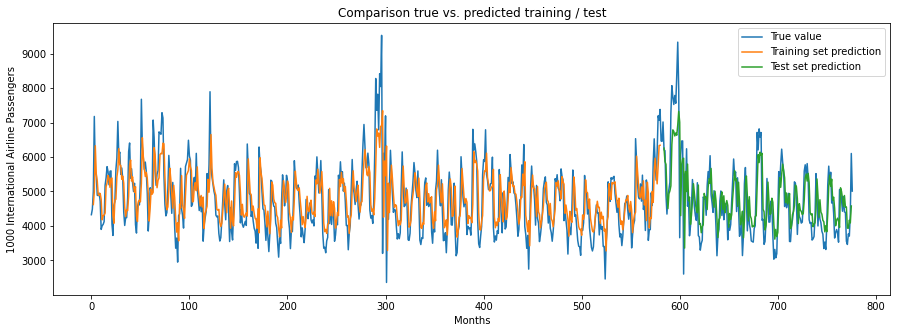

In [11]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Months")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()

In [12]:
out = test_predict.astype(np.int)
pd.DataFrame(out).to_csv(r'C:\Users\gurpr\Videos\BetaSci\lstm_pred_win2.csv', index=False, header=False)
